In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx

In [2]:
mypath = '/home/selihadji/Documenti/papers/Platoon_II/trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_14'
onlyfiles_14_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_14_09

searchString = '08_4'

onlyfiles = filterSubstr(onlyfiles_14_09, searchString)
onlyfiles

#searchString2 = '_12_28'
#onlyfiles2 = filterSubstr(onlyfiles_14_09, searchString2)
#onlyfiles = onlyfiles1 + onlyfiles2
#onlyfiles

['2022_09_14_PS Skylark Test_08_42_09_04_5e344b30-bdcc-4c93-9b90-384ff4d2de99.csv',
 '2022_09_14_RG Logi Jeep_08_43_09_04_82712b35-10d7-4249-8dbe-59f6a87e00ff.csv',
 '2022_09_14_LA2 Logi Jeep_08_43_09_01_fb557098-4c2a-4ad4-827d-c6b267eb3eba.csv']

In [5]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [6]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [7]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [8]:
alldata_RG = alldata[alldata.driver == 'RG']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_LA = alldata[alldata.driver == 'LA']

In [9]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [10]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [11]:
alldata.driver.unique()

array(['PS', 'RG', 'LA'], dtype=object)

In [12]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [13]:
alldata_SORTED_cut = alldata_SORTED.dropna().reset_index(drop=True)

In [14]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [15]:
rg = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RG'].reset_index(drop=True).drop_duplicates()
la = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'LA'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [16]:
from haversine import haversine, Unit
import haversine as hs

In [17]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#ps --> rg
#jc --> la
#dw --> ps


for i in range(len(rg)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rg_ = rg.iloc[i]
    
    df_array1 = (rg_.Latitude, rg_.Longitude)

    la_ = la[la['Time'] > rg_['Time']].reset_index(drop=True)
    df_array2 = list(zip(la_.Latitude, la_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    la_mindist = min(dist_mat)
    la_mindist_index = dist_mat.index(la_mindist)

    platoon_dist.append(la_mindist)

    platoon_lat_dist.append(la_.iloc[la_mindist_index]["Latitude"])
    platoon_lon_dist.append(la_.iloc[la_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(la_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(la_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    la_maxCO2 = max(CO2)
    la_maxCO2_index = CO2.index(la_maxCO2)
    CO2_max.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > la_['Time'][la_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[la_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

ValueError: min() arg is an empty sequence

<Axes: >

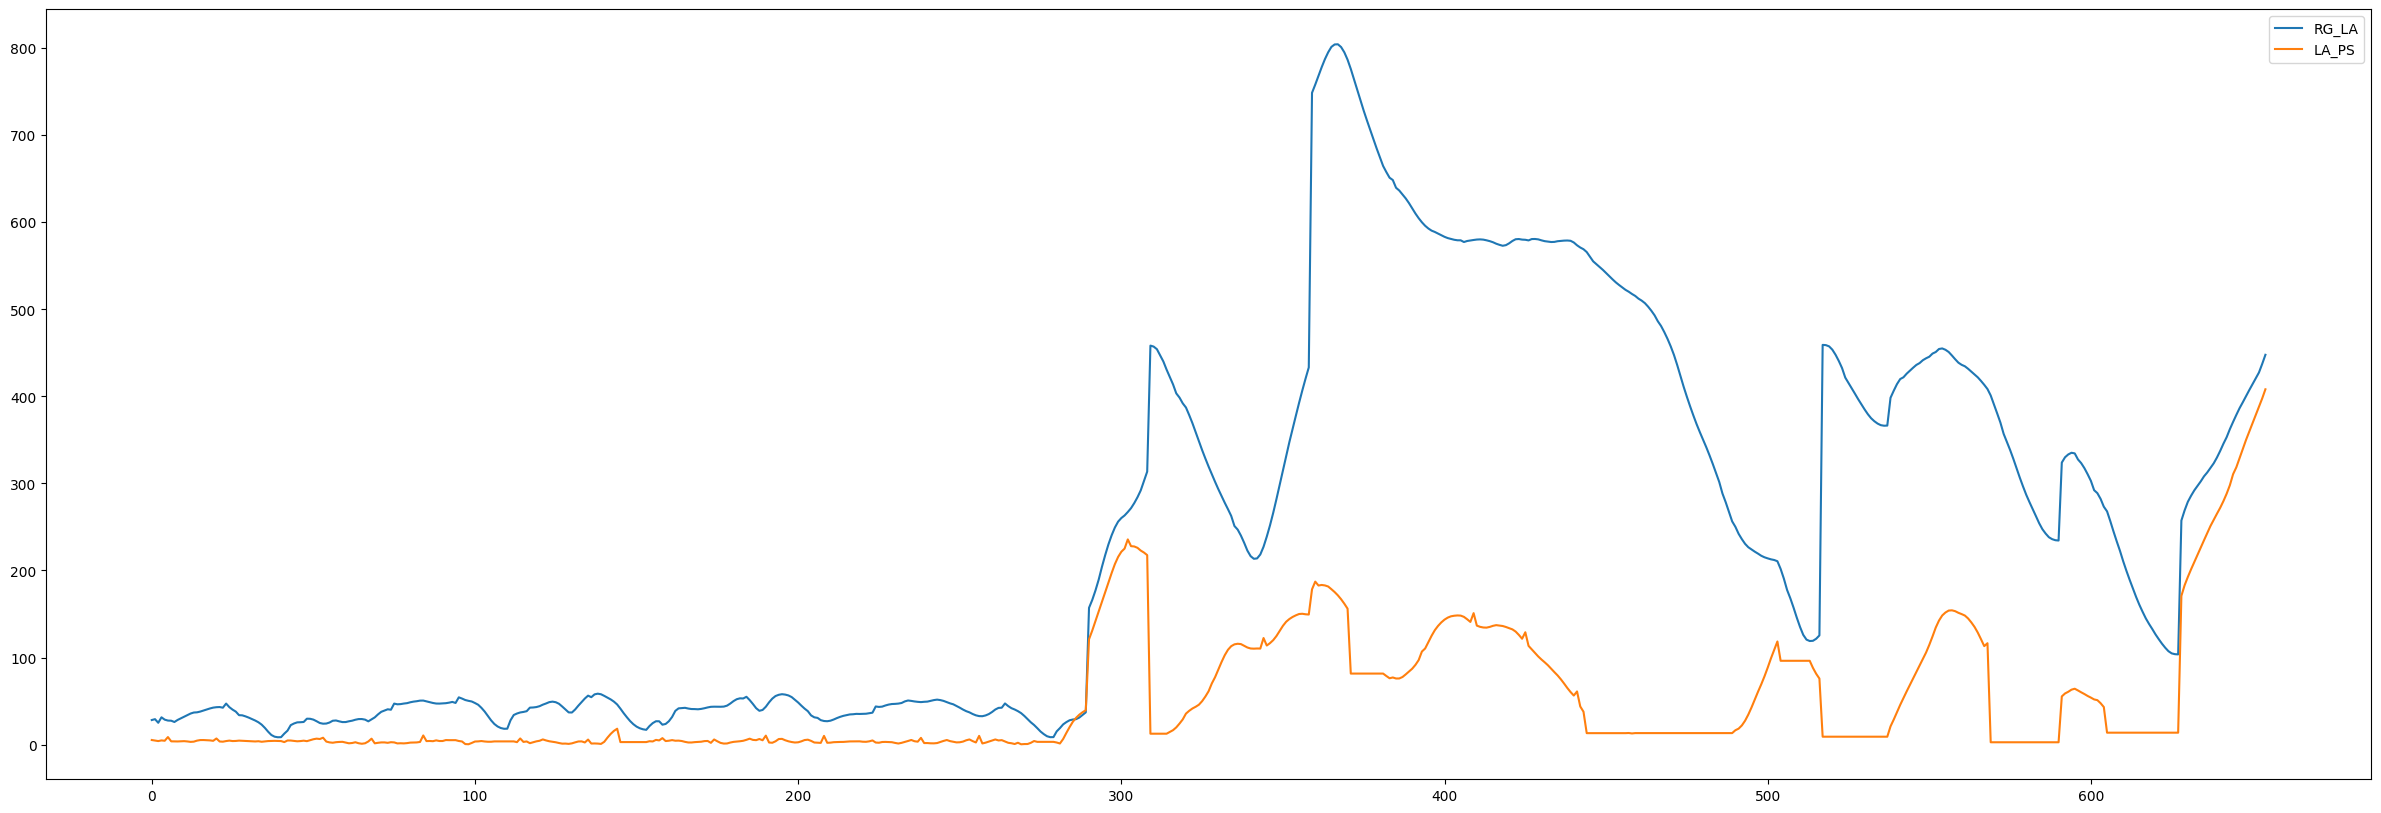

In [18]:
pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS']).plot(figsize=(30,10))

In [19]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS'])
pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS']).to_csv('distance_platoon.csv', index=False)

In [20]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

In [21]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [22]:
infr = pd.read_csv('/home/selihadji/Documenti/papers/Platoon_II/infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [23]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lon,infr.iloc[j].lat)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k+1])], dist_coord.iloc[i][str(dist_coord.columns[k])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [24]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [25]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [26]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [27]:
v1.columns = infr.what
v2.columns = infr.what

In [28]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [29]:
import statsmodels.api as sm

In [30]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.684
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              200.2
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   2.07e-157
Time:                        09:04:45   Log-Likelihood:                         -3511.3
No. Observations:                 655   AIC:                                      7037.
Df Residuals:                     648   BIC:                                      7068.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection    70.3998     16.469      4.275      0.000      38.061     102.739
Feat_Curve                  77.7330     17.049      4.559      0.000      44.255     111.211
Feat_Road_immission         -9.4567      8.723     -1.084      0.279     -26.585       7.672
Feat_Traffic_light          18.5132      3.420      5.413      0.000      11.797      25.229
Feat_Turn_left               1.2309     11.303      0.109      0.913     -20.963      23.425
Feat_Turn_right             11.0037      6.484      1.697      0.090      -1.728      23.736
old_dist                     0.8188      0.031     26.217      0.000       0.758       0.880
==============================================================================
Omnibus:                       97.378   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              766.511
Skew:                           0.375   Prob(JB):                    3.58e-167
Kurtosis:                       8.246   Cond. No.                         677.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_14_09_08_42_09.csv')

In [32]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] <80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.503
Model:                            OLS   Adj. R-squared (uncentered):              0.498
Method:                 Least Squares   F-statistic:                              93.76
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                    3.84e-94
Time:                        09:04:46   Log-Likelihood:                          2789.8
No. Observations:                 655   AIC:                                     -5566.
Df Residuals:                     648   BIC:                                     -5534.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0003      0.001      0.285      0.776      -0.002       0.002
Feat_Curve                   0.0006      0.001      0.565      0.572      -0.002       0.003
Feat_Road_immission          0.0050      0.001      8.701      0.000       0.004       0.006
Feat_Traffic_light           0.0028      0.000     12.487      0.000       0.002       0.003
Feat_Turn_left               0.0054      0.001      7.182      0.000       0.004       0.007
Feat_Turn_right              0.0064      0.000     14.817      0.000       0.006       0.007
old_dist                  6.039e-06   2.07e-06      2.912      0.004    1.97e-06    1.01e-05
==============================================================================
Omnibus:                       38.556   Durbin-Watson:                   0.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.018
Skew:                           0.401   Prob(JB):                     8.24e-07
Kurtosis:                       2.381   Cond. No.                         677.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_14_09_08_42_09_CO2.csv')